In [14]:
pd.set_option("display.max_colwidth", 80)

In [1]:
# imageのsizeを特徴量として追加

VALID = True
import time

notebookstart = time.time()

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

path = "/Users/um003580/projects/kaggle/avito/input"

print("Data:\n", os.listdir(path))

# Models Packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Gradient Boosting
import lightgbm as lgb

# Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords

# Viz
import seaborn as sns
import matplotlib.pyplot as plt

Data:
 ['test_active.csv', 'train_active.csv', '.DS_Store', 'periods_train.csv', 'test.csv', 'train_jpg_nan', 'train_jpg_0', 'train_jpg_1', 'aggregated_features.csv', 'periods_test.csv', 'train.csv', 'train_jpg_4', 'sample_submission.csv']


In [2]:
# Thanks You Guillaume Martin for the Awesome Memory Optimizer!
# https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [7]:
print("\nData Load Stage")
training = pd.read_csv(path+'/train.csv', index_col="item_id", parse_dates=["activation_date"])  # .sample(1000)
traindex = training.index
testing = pd.read_csv(path+'/test.csv', index_col="item_id", parse_dates=["activation_date"])  # .sample(1000)
testdex = testing.index
y = training.deal_probability.copy().clip(0.0, 1.0)
training.drop("deal_probability", axis=1, inplace=True)
print('Train shape: {} Rows, {} Columns'.format(*training.shape))
print('Test shape: {} Rows, {} Columns'.format(*testing.shape))


Data Load Stage
Train shape: 1503424 Rows, 16 Columns
Test shape: 508438 Rows, 16 Columns


In [8]:
print("Combine Train and Test")
df = pd.concat([training, testing], axis=0)
del training, testing
gc.collect()
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))

Combine Train and Test

All Data shape: 2011862 Rows, 16 Columns


In [9]:
print("Feature Engineering")
df["price"] = np.log(df["price"] + 0.001)
# df["price"].fillna(-999, inplace=True)
df["image_top_1"].fillna(-999, inplace=True)

print("\nCreate Time Variables")
df["Weekday"] = df['activation_date'].dt.weekday
df["Weekd of Year"] = df['activation_date'].dt.week
df["Day of Month"] = df['activation_date'].dt.day

# Create Validation Index and Remove Dead Variables
# training_index = df.loc[df.activation_date<=pd.to_datetime('2017-04-07')].index
# validation_index = df.loc[df.activation_date>=pd.to_datetime('2017-04-08')].index
# df.drop(["activation_date", "image"], axis=1, inplace=True)
df.drop(["activation_date"], axis=1, inplace=True)

Feature Engineering

Create Time Variables


In [10]:
ag = pd.read_csv(path+'/aggregated_features.csv')
df = df.merge(ag, on='user_id', how='left').set_index(df.index)
df.head()

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,...,item_seq_number,user_type,image,image_top_1,Weekday,Weekd of Year,Day of Month,avg_days_up_user,avg_times_up_user,n_user_items
item_id,,,,,,,,,,,,,,,,,,,,,
b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",...,2,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,1,13,28,8.000000,2.000000,2
2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",...,19,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,6,12,26,NaN,NaN,1
ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",...,9,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0,12,20,4.428571,1.142857,9
02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,...,286,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,5,12,25,16.714286,2.642857,32
7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,...,3,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,3,11,16,NaN,NaN,1


In [15]:
image_sizes = pd.read_csv('image_sizes.csv')
image_sizes.head()

,image,size
0,845defffcb3876df3c272bbe807e21d6b028a67dafb68a4ef3e81b81a89164b9,31533
1,86c463c915b2a3474e909a619d9b09cfd3c8bb4c3790920d7722d8fb79e59495,32325
2,053126195bf9301ea10f0eb3b2c8f09c0f17c94aa99aac6484da49c0dd57eea0,35761
3,dd112eba060070f610d89677a8987ffa3e7f95cb301b04a0817297ef0213c406,78887
4,a49d4f24f0de7e542161a1932e50666fc40bddcdecc855b066a6ee34369e1926,36678


In [16]:
df = df.merge(image_sizes, on='image', how='left').set_index(df.index)
df.head()

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,...,user_type,image,image_top_1,Weekday,Weekd of Year,Day of Month,avg_days_up_user,avg_times_up_user,n_user_items,size
item_id,,,,,,,,,,,,,,,,,,,,,
b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяца.цвет серый",...,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c7679f17c333c959b19,1008.0,1,13,28,8.000000,2.000000,2,27039.0
2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",...,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d71427001e1e0859c0fb843a31,692.0,6,12,26,NaN,NaN,1,30385.0
ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ray, USB. Если настроить, то р...",...,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a8713f112c67e29bb42,3032.0,0,12,20,4.428571,1.142857,9,18681.0
02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,...,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c841302bf49820803501b4b,796.0,5,12,25,16.714286,2.642857,32,13656.0
7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,...,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2c089d8376e883ed33b,2264.0,3,11,16,NaN,NaN,1,36710.0


In [17]:
df.drop(["image"], axis=1, inplace=True)

In [29]:
print("\nEncode Variables")
categorical = ["user_id", "region", "city", "parent_category_name", "category_name", "user_type",
               "image_top_1", "param_1", "param_2", "param_3"]
print("Encoding :", categorical)

# Encoder:
lbl = preprocessing.LabelEncoder()
for col in categorical:
    df[col] = lbl.fit_transform(df[col].astype(str))


Encode Variables
Encoding : ['user_id', 'region', 'city', 'parent_category_name', 'category_name', 'user_type', 'image_top_1', 'param_1', 'param_2', 'param_3']


KeyboardInterrupt: 

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/um003580/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
print("\nText Features")
# Feature Engineering
# Meta Text Features
textfeats = ["description", "title"]

for cols in textfeats:
    df[cols] = df[cols].astype(str)
    df[cols] = df[cols].astype(str).fillna('missing')  # FILL NA
    df[cols] = df[cols].str.lower()  # Lowercase all text, so that capitalized words dont get treated differently
    df[cols + '_num_words'] = df[cols].apply(lambda comment: len(comment.split()))  # Count number of Words
    df[cols + '_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
    df[cols + '_words_vs_unique'] = df[cols + '_num_unique_words'] / df[cols + '_num_words'] * 100  # Count Unique Words


Text Features


In [21]:
print("\n[TF-IDF] Term Frequency Inverse Document Frequency Stage")
russian_stop = set(stopwords.words('russian'))

tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    # "min_df":5,
    # "max_df":.9,
    "smooth_idf": False
}


def get_col(col_name): return lambda x: x[col_name]


##I added to the max_features of the description. It did not change my score much but it may be worth investigating
vectorizer = FeatureUnion([
    ('description', TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=17000,
        **tfidf_para,
        preprocessor=get_col('description'))),
    ('title', CountVectorizer(
        ngram_range=(1, 2),
        stop_words=russian_stop,
        # max_features=7000,
        preprocessor=get_col('title')))
])

start_vect = time.time()

# Fit my vectorizer on the entire dataset instead of the training rows
# Score improved by .0001
vectorizer.fit(df.to_dict('records'))
ready_df = vectorizer.transform(df.to_dict('records'))


[TF-IDF] Term Frequency Inverse Document Frequency Stage


In [22]:
tfvocab = vectorizer.get_feature_names()
print("Vectorization Runtime: %0.2f Minutes" % ((time.time() - start_vect) / 60))

# Drop Text Cols
df.drop(textfeats, axis=1, inplace=True)

# Dense Features Correlation Matrix
# f, ax = plt.subplots(figsize=[10, 7])
# sns.heatmap(pd.concat([df.loc[traindex, [x for x in df.columns if x not in categorical]], y], axis=1).corr(),
#             annot=False, fmt=".2f", cbar_kws={'label': 'Correlation Coefficient'}, cmap="plasma", ax=ax, linewidths=.5)
# ax.set_title("Dense Features Correlation Matrix")
# plt.savefig('correlation_matrix.png')

print("Modeling Stage")
# Reduce Memory (See function up top)
df = reduce_mem_usage(df)

Vectorization Runtime: 10.31 Minutes
Modeling Stage
Memory usage of dataframe is 399.08 MB
Memory usage after optimization is: 105.53 MB
Decreased by 73.6%


In [49]:
# df['price'].replace({-999: np.nan}, inplace=True)

In [30]:
df.head()

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,price,item_seq_number,...,description_num_words,description_num_unique_words,description_words_vs_unique,title_num_words,title_num_unique_words,title_words_vs_unique,parent_category_mean,parent_category_median,category_mean,category_median
item_id,,,,,,,,,,,,,,,,,,,,,
b912c3c6a6ad,881323,11,1156,4,37,249,112,1217,5.992188,2,...,7,7,100.0,3,3,100.0,6.613281,6.535156,7.234375,7.312500
2dac0150717d,152032,9,352,2,15,122,112,1217,8.007812,19,...,7,7,100.0,3,3,100.0,7.378906,7.601562,7.808594,8.007812
ba83aefab5dc,539091,8,325,0,12,84,112,1217,8.296875,9,...,17,17,100.0,2,2,100.0,7.781250,7.882812,7.601562,7.601562
02996f1dd2ea,737786,14,1698,4,37,38,112,1217,7.695312,286,...,3,3,100.0,1,1,100.0,6.613281,6.535156,7.234375,7.312500
7c90be56d2ab,948093,22,996,6,0,278,124,46,10.593750,3,...,4,4,100.0,3,3,100.0,12.132812,12.304688,12.281250,12.375000


In [24]:
y.head()

item_id
b912c3c6a6ad    0.12789
2dac0150717d    0.00000
ba83aefab5dc    0.43177
02996f1dd2ea    0.80323
7c90be56d2ab    0.20797
Name: deal_probability, dtype: float64

In [25]:
parent_prices = df.groupby('parent_category_name').agg({'price':['mean','median']}).reset_index()
parent_prices.columns = ['parent_category_name','parent_category_mean','parent_category_median']
df = pd.merge(df, parent_prices, on='parent_category_name',how='left').set_index(df.index)

,parent_category_name,parent_category_mean,parent_category_median
0,0,7.781250,7.882812
1,1,9.843750,9.906250
2,2,7.378906,7.601562
3,3,6.207031,6.906250
4,4,6.613281,6.535156
5,5,13.187500,14.070312
6,6,12.132812,12.304688
7,7,5.878906,6.214844
8,8,7.246094,7.312500


In [27]:
prices = df.groupby('category_name').agg({'price':['mean','median']}).reset_index()
prices.columns = ['category_name','category_mean','category_median']
df = pd.merge(df, prices, on='category_name',how='left').set_index(df.index)

,category_name,category_mean,category_median
0,0,12.281250,12.375000
1,1,6.023438,6.214844
2,2,7.601562,7.601562
3,3,8.828125,9.210938
4,4,7.925781,8.007812
5,5,8.289062,8.453125
6,6,10.804688,10.671875
7,7,11.281250,11.921875
8,8,12.273438,12.609375
9,9,12.515625,12.609375


In [31]:
del parent_prices,prices

In [33]:
df['parent_category_mean_diff'] = df['price'] - df['parent_category_mean']
df['parent_category_median_diff'] = df['price'] - df['parent_category_median']
df['category_mean_diff'] = df['price'] - df['category_mean']
df['category_median_diff'] = df['price'] - df['category_median']

In [34]:
df.head(20)

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,price,item_seq_number,...,title_num_unique_words,title_words_vs_unique,parent_category_mean,parent_category_median,category_mean,category_median,parent_category_mean_diff,parent_category_median_diff,category_mean_diff,category_median_diff
item_id,,,,,,,,,,,,,,,,,,,,,
b912c3c6a6ad,881323,11,1156,4,37,249,112,1217,5.992188,2,...,3,100.0,6.613281,6.535156,7.234375,7.312500,-0.621094,-0.542969,-1.242188,-1.320312
2dac0150717d,152032,9,352,2,15,122,112,1217,8.007812,19,...,3,100.0,7.378906,7.601562,7.808594,8.007812,0.628906,0.406250,0.199219,0.000000
ba83aefab5dc,539091,8,325,0,12,84,112,1217,8.296875,9,...,2,100.0,7.781250,7.882812,7.601562,7.601562,0.515625,0.414062,0.695312,0.695312
02996f1dd2ea,737786,14,1698,4,37,38,112,1217,7.695312,286,...,1,100.0,6.613281,6.535156,7.234375,7.312500,1.082031,1.160156,0.460938,0.382812
7c90be56d2ab,948093,22,996,6,0,278,124,46,10.593750,3,...,3,100.0,12.132812,12.304688,12.281250,12.375000,-1.539062,-1.710938,-1.687500,-1.781250
51e0962387f7,722980,14,752,4,37,38,112,1217,7.171875,9,...,2,100.0,6.613281,6.535156,7.234375,7.312500,0.558594,0.636719,-0.062500,-0.140625
c4f260a2b48a,290934,3,1736,2,32,283,112,1217,9.304688,125,...,5,100.0,7.378906,7.601562,7.304688,7.601562,1.925781,1.703125,2.000000,1.703125
6b71309d6a8a,6540,7,185,4,22,126,141,75,6.214844,61,...,2,100.0,6.613281,6.535156,6.804688,6.800781,-0.398438,-0.320312,-0.589844,-0.585938
c5b969cb63a2,131123,6,134,4,22,126,208,219,6.214844,85,...,1,100.0,6.613281,6.535156,6.804688,6.800781,-0.398438,-0.320312,-0.589844,-0.585938


In [38]:
#pikle化
import pickle
with open('df.csv.pkl','wb') as f:
  pickle.dump(df,f,protocol=4)

with open('y.csv.pkl','wb') as f:
  pickle.dump(y,f,protocol=4)

with open('ready_df.pkl','wb') as f:
  pickle.dump(ready_df,f,protocol=4)

with open('traindex.pkl','wb') as f:
  pickle.dump(traindex,f,protocol=4)

with open('testdex.pkl','wb') as f:
  pickle.dump(testdex,f,protocol=4)

with open('tfvocab.pkl','wb') as f:
  pickle.dump(tfvocab,f,protocol=4)

with open('categorical.pkl','wb') as f:
  pickle.dump(categorical,f,protocol=4)


# import pickle
# # with timer("Loading done"):
# with open('df.csv.pkl','rb') as f:
#     df = pickle.load(f)

# with open('y.csv.pkl','rb') as f:
#     y = pickle.load(f)

In [39]:
# Combine Dense Features with Sparse Text Bag of Words Features
X = hstack([csr_matrix(df.loc[traindex, :].values), ready_df[0:traindex.shape[0]]])  # Sparse Matrix
testing = hstack([csr_matrix(df.loc[testdex, :].values), ready_df[traindex.shape[0]:]])
tfvocab = df.columns.tolist() + tfvocab
for shape in [X, testing]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ", len(tfvocab))
del df, ready_df
gc.collect();

1503424 Rows and 1430256 Cols
508438 Rows and 1430256 Cols
Feature Names Length:  1430256


In [40]:
print("\nModeling Stage")
print("Light Gradient Boosting Regressor")

n_rounds = 5000
lgbm_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    # 'max_depth': 5,
    'num_leaves': 31,
    # 'feature_fraction': 0.65,
    'bagging_fraction': 0.9,
    'min_sum_hessian_in_leaf': 1,
    'lambda_l1': 0.4,
    'lambda_l2': 0.6,
    'seed': 99,
    # 'bagging_freq': 5,
    'learning_rate': 0.05,
    'verbose': 0
}

# Training and Validation Set
modelstart = time.time()
if VALID == True:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.10, random_state=99)

    # LGBM Dataset Formatting
    lgtrain = lgb.Dataset(X_train, y_train,
                          feature_name=tfvocab,
                          categorical_feature=categorical)
    lgvalid = lgb.Dataset(X_valid, y_valid,
                          feature_name=tfvocab,
                          categorical_feature=categorical)
    del X, X_train;
    gc.collect()

    # Go Go Go
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=n_rounds,
        valid_sets=[lgvalid],
        valid_names=['valid'],
        early_stopping_rounds=50,
        verbose_eval=20
    )
    print("Model Evaluation Stage")
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, lgb_clf.predict(X_valid))))
    del X_valid;
    gc.collect()

else:
    # LGBM Dataset Formatting
    lgtrain = lgb.Dataset(X, y,
                          feature_name=tfvocab,
                          categorical_feature=categorical)
    del X;
    gc.collect()
    # Go Go Go
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=n_rounds,
        verbose_eval=20
    )


Modeling Stage
Light Gradient Boosting Regressor


/Users/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 50 rounds.
[20]	valid's rmse: 0.235388
[40]	valid's rmse: 0.22982
[60]	valid's rmse: 0.227725
[80]	valid's rmse: 0.226515
[100]	valid's rmse: 0.225661
[120]	valid's rmse: 0.225001
[140]	valid's rmse: 0.224524
[160]	valid's rmse: 0.224064
[180]	valid's rmse: 0.223739
[200]	valid's rmse: 0.223439
[220]	valid's rmse: 0.223191
[240]	valid's rmse: 0.222942
[260]	valid's rmse: 0.222741
[280]	valid's rmse: 0.222548
[300]	valid's rmse: 0.222393
[320]	valid's rmse: 0.222252
[340]	valid's rmse: 0.222107
[360]	valid's rmse: 0.221984
[380]	valid's rmse: 0.22186
[400]	valid's rmse: 0.221761
[420]	valid's rmse: 0.221652
[440]	valid's rmse: 0.221558
[460]	valid's rmse: 0.221457
[480]	valid's rmse: 0.221376
[500]	valid's rmse: 0.221292
[520]	valid's rmse: 0.221208
[540]	valid's rmse: 0.221148
[560]	valid's rmse: 0.221088
[580]	valid's rmse: 0.221031
[600]	valid's rmse: 0.220957
[620]	valid's rmse: 0.220908
[640]	valid's rmse: 0.220865
[660]	valid's rm

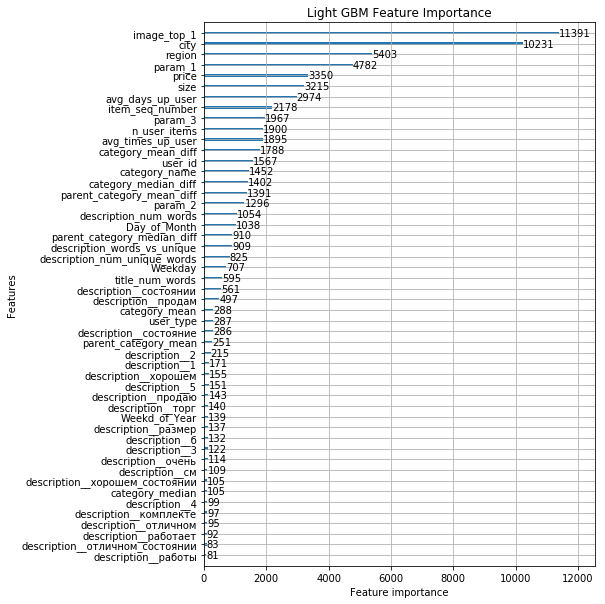

In [41]:
# Feature Importance Plot
f, ax = plt.subplots(figsize=[7, 10])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")
plt.savefig('feature_importance.png')

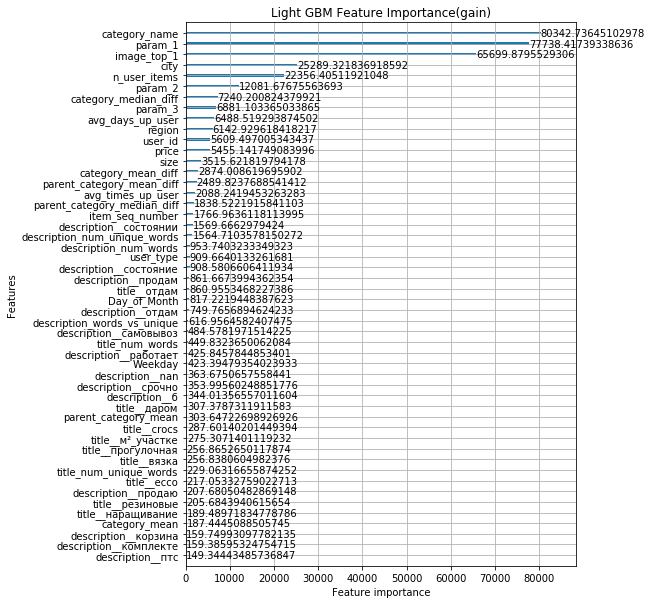

In [42]:
f, ax = plt.subplots(figsize=[7, 10])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax, importance_type='gain')
plt.title("Light GBM Feature Importance(gain)")
plt.savefig('feature_importance_gain.png')

In [43]:
lgpred = lgb_clf.predict(testing)
del testing;
gc.collect()

/Users/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/lightgbm/basic.py:447: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


43

In [44]:
lgsub = pd.DataFrame(lgpred, columns=["deal_probability"], index=testdex)
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True)  # Between 0 and 1
lgsub.to_csv("lgsub.csv", index=True, header=True)
print("Model Runtime: %0.2f Minutes" % ((time.time() - modelstart) / 60))
print("Notebook Runtime: %0.2f Minutes" % ((time.time() - notebookstart) / 60))

Model Runtime: 51.54 Minutes
Notebook Runtime: 111.88 Minutes
